In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

In [199]:
data_dir = '/Users/musa/Desktop/raspberrypi-recordings/recordings-4-7-25'

In [200]:
dirs = [d for d in Path(data_dir).iterdir() if d.is_dir()]
dirs.sort(key=lambda x: x.stem.split('-')[1:])
dirs

[PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-7-25/Musa-2025-03-24-22-30-31'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-7-25/Musa-2025-03-24-22-35-09'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-7-25/Musa-2025-03-24-22-40-14'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-7-25/Musa-2025-03-24-22-46-49')]

In [ ]:
d = dirs[3]

print(d.name)
df_emg = pd.read_csv(d / 'emg.csv')
df_imu = pd.read_csv(d / 'imu.csv')

print(df_emg.shape, df_imu.shape)

i=2.5
df_emg = df_emg.iloc[int(i*1000):]
df_imu = df_imu.iloc[int(i*100):]
print(df_emg.shape, df_imu.shape)

# df_emg.to_csv(d / 'emg.csv', index=False)
# df_imu.to_csv(d / 'imu.csv', index=False)


Musa-2025-03-24-22-46-49
(44001, 2) (4401, 7)
(41501, 2) (4151, 7)


Musa-2025-03-24-22-30-31
(51501, 2) (5151, 7) {'name': 'Musa', 'age': 21, 'weight': 200, 'sex': 'M', 'location': 'Studio fit', 'machine_weight': 110, 'start_time': 1742869831.3271017, 'notes': '', 'end_rep_markers': [9.2, 14.2, 19, 24, 29.5, 36, 44.5, 54]}
Total reps: 8
Rep 1/8: 9.20 s
Rep 2/8: 5.00 s
Rep 3/8: 4.80 s
Rep 4/8: 5.00 s
Rep 5/8: 5.50 s
Rep 6/8: 6.50 s
Rep 7/8: 8.50 s
Rep 8/8: 9.50 s
(45791, 3) (4580, 8) {'name': 'Musa', 'age': 21, 'weight': 200, 'sex': 'M', 'location': 'Studio fit', 'machine_weight': 110, 'start_time': 1742869831.3271017, 'notes': '', 'end_rep_markers': [9.2, 14.2, 19, 24, 29.5, 36, 44.5, 54]}


Text(0.5, 0.98, 'Musa-2025-03-24-22-30-31')

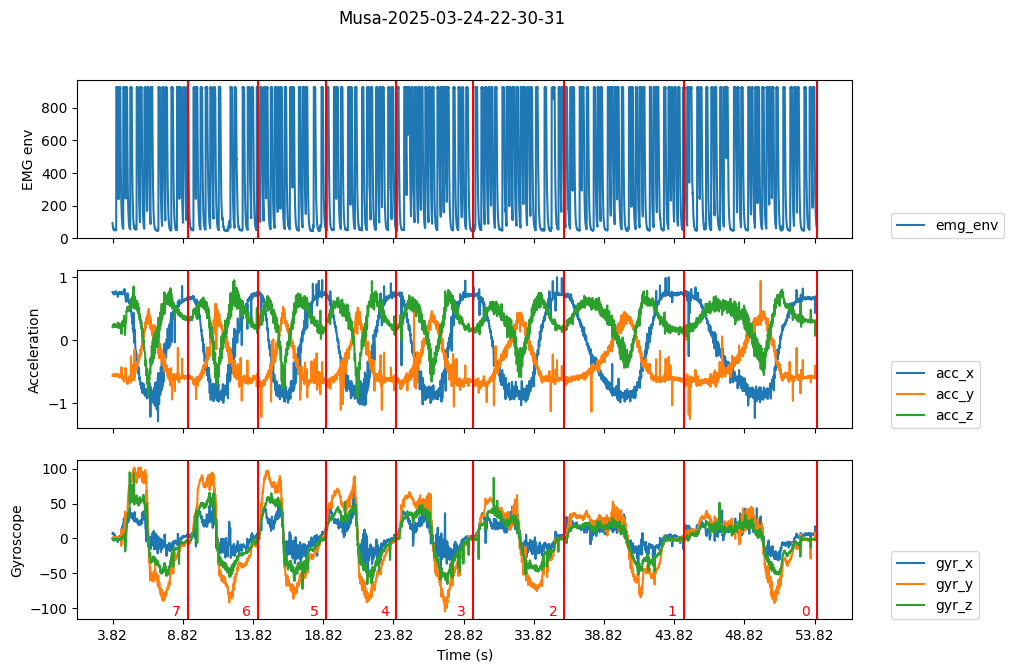

In [314]:
## FOR version 2 - emg.csv (1000 Hz) and imu.csv (100 Hz) - values not normalized
d = dirs[0]

print(d.name)
df_emg = pd.read_csv(d / 'emg.csv')
df_imu = pd.read_csv(d / 'imu.csv')
info = json.load(open(d / 'info.json'))
print(df_emg.shape, df_imu.shape, info)

total_reps = len(info['end_rep_markers'])
print('Total reps:', total_reps)
df_emg['rir'] = -1
df_imu['rir'] = -1
print(f'Rep 1/{total_reps}: {info["end_rep_markers"][0]:.2f} s')
df_emg.loc[df_emg['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
df_imu.loc[df_imu['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
    print(f'Rep {i+2}/{total_reps}: {end-start:.2f} s')
    df_emg.loc[df_emg['time'].between(start, end), 'rir'] = total_reps - i - 2
    df_imu.loc[df_imu['time'].between(start, end), 'rir'] = total_reps - i - 2
df_emg = df_emg[df_emg['rir'] != -1]
df_imu = df_imu[df_imu['rir'] != -1]

i=0
df_emg = df_emg.iloc[int(i*1000):]
df_imu = df_imu.iloc[int(i*100):]
print(df_emg.shape, df_imu.shape, info)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(df_emg['time'], df_emg['emg_env'], label='emg_env')
axes[1].plot(df_imu['time'], df_imu[['acc_x', 'acc_y', 'acc_z']] / 16384.0, label=['acc_x', 'acc_y', 'acc_z'])
axes[2].plot(df_imu['time'], df_imu[['gyr_x', 'gyr_y', 'gyr_z']] / 131.0, label=['gyr_x', 'gyr_y', 'gyr_z'])

axes[0].set_ylabel('EMG env')
axes[1].set_ylabel('Acceleration')
axes[2].set_ylabel('Gyroscope')
axes[2].set_xlabel('Time (s)')
[ax.legend(loc=(1.05, 0)) for ax in axes]

axes[2].set_xticks(np.arange(
    min(df_emg['time'].iloc[0], df_imu['time'].iloc[0]), 
    min(df_emg['time'].iloc[-1], df_imu['time'].iloc[-1]),
    5
))

for i,end_rep_mark in enumerate(info['end_rep_markers']):
    [ax.axvline(end_rep_mark, color='r') for ax in axes if end_rep_mark > df_emg['time'].iloc[0]]
    axes[2].text(end_rep_mark - 0.5, 0.02, total_reps - i - 1, transform=axes[2].get_xaxis_transform(), color='r', horizontalalignment='right')

plt.suptitle(d.stem)

Musa-2025-03-07-00-43-54
(7262, 8) {'name': 'Musa', 'age': 21, 'weight': 210, 'sex': 'm', 'start_time': 1741326234.7817495, 'notes': '90 lbs', 'end_rep_markers': [6.334286451339722, 9.922213315963745, 13.493896722793579, 17.633913278579712, 21.447482109069824, 25.910588264465332, 30.80106019973755, 35.740480184555054, 42.3082332611084, 47.97752857208252, 53.77577042579651]}
Total reps: 11
Rep 1/11: 6.33 s
Rep 2/11: 3.59 s
Rep 3/11: 3.57 s
Rep 4/11: 4.14 s
Rep 5/11: 3.81 s
Rep 6/11: 4.46 s
Rep 7/11: 4.89 s
Rep 8/11: 4.94 s
Rep 9/11: 6.57 s
Rep 10/11: 5.67 s
Rep 11/11: 5.80 s
(6155, 9)


Text(0.5, 0.98, 'Musa-2025-03-07-00-43-54')

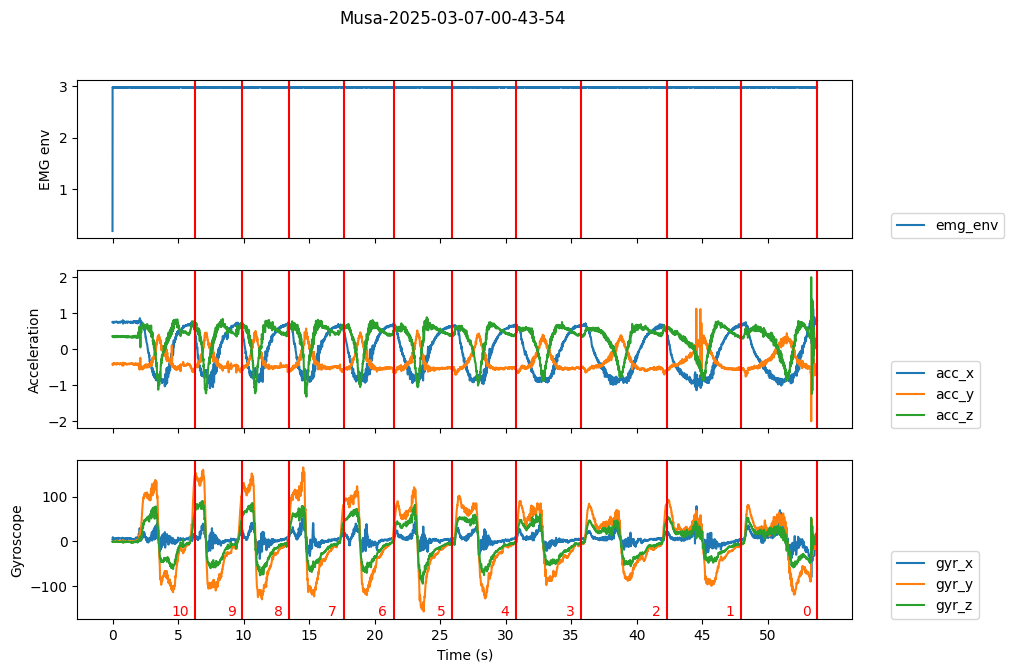

In [198]:
## FOR version 1 - emg and imu in one file (data.csv) - values already normalized

d = dirs[8]

print(d.name)
df = pd.read_csv(d / 'data.csv')
df['emg_env']
info = json.load(open(d / 'info.json'))
print(df.shape, info)

total_reps = len(info['end_rep_markers'])
print('Total reps:', total_reps)
df['rir'] = -1
print(f'Rep 1/{total_reps}: {info["end_rep_markers"][0]:.2f} s')
df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
    print(f'Rep {i+2}/{total_reps}: {end-start:.2f} s')
    df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
df = df[df['rir'] != -1]

i=0
df = df.iloc[int(i*100):]
print(df.shape)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(df['time'], df['emg_env'], label='emg_env')
axes[1].plot(df['time'], df[['acc_x', 'acc_y', 'acc_z']], label=['acc_x', 'acc_y', 'acc_z'])
axes[2].plot(df['time'], df[['gyr_x', 'gyr_y', 'gyr_z']], label=['gyr_x', 'gyr_y', 'gyr_z'])

axes[0].set_ylabel('EMG env')
axes[1].set_ylabel('Acceleration')
axes[2].set_ylabel('Gyroscope')
axes[2].set_xlabel('Time (s)')
[ax.legend(loc=(1.05, 0)) for ax in axes]

axes[2].set_xticks(np.arange(df['time'].iloc[0], df['time'].iloc[-1], 5))

for i,end_rep_mark in enumerate(info['end_rep_markers']):
    [ax.axvline(end_rep_mark, color='r') for ax in axes if end_rep_mark > df['time'].iloc[0]]
    axes[2].text(end_rep_mark - 0.5, 0.02, total_reps - i - 1, transform=axes[2].get_xaxis_transform(), color='r', horizontalalignment='right')

plt.suptitle(d.stem)

In [315]:
def label_rir(df, info):
    total_reps = len(info['end_rep_markers'])
    df['rir'] = -1
    df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
    for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
        df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
    df = df[df['rir'] != -1]

In [316]:
data_dirs = [
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-07-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-11-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-15-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-4-3-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-4-7-25',
]

In [317]:
not_labelled_each = [[0],[],[],[],[]]
use_old = [True, True, True, False, False]
dfs =[]
outdir = Path('data/')
outdir.mkdir(exist_ok=True, parents=True)
session_id = 0
for data_dir, not_labelled, use_oldi in zip(data_dirs, not_labelled_each, use_old):
    dirs = [d for d in Path(data_dir).iterdir() if d.is_dir()]
    for d in [dirs[i] for i in range(len(dirs)) if i not in not_labelled]:
        name = d.name.split('-')[0]
        if use_oldi:
            df = pd.read_csv(d / 'data.csv').drop(columns=['emg_env'])
        else:
            df = pd.read_csv(d / 'imu.csv')
            df[['acc_x', 'acc_y', 'acc_z']] = df[['acc_x', 'acc_y', 'acc_z']] / 16384.0
            df[['gyr_x', 'gyr_y', 'gyr_z']] = df[['gyr_x', 'gyr_y', 'gyr_z']] / 131.0
        
        info = json.load(open(d / 'info.json'))
        label_rir(df, info)
        
        df['id'] = name
        df['session_id'] = session_id
        df = df[df['rir'] != -1]    # cut off after last rep
        dfs.append(df)
        session_id += 1
df = pd.concat(dfs)
df.to_csv(outdir / 'data.csv', index=False)

In [318]:
X = df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
y = df['rir'].values

In [319]:
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [320]:
hz = 100
X_windowed = []
y_windowed = []
window_t = 2.5
window_size = int(hz * window_t)    # 2.5 seconds
stride_t = 0.5
stride = int(hz * stride_t)         # 0.5 seconds
for i in range(0, len(X) - window_size, stride):
    X_windowed.append(X[i:i+window_size])
    y_windowed.append(y[i:i+window_size].mean())
X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)
print(X_windowed.shape, y_windowed.shape)

(2880, 250, 6) (2880,)


Text(0.5, 1.0, 'Rir=10.0')

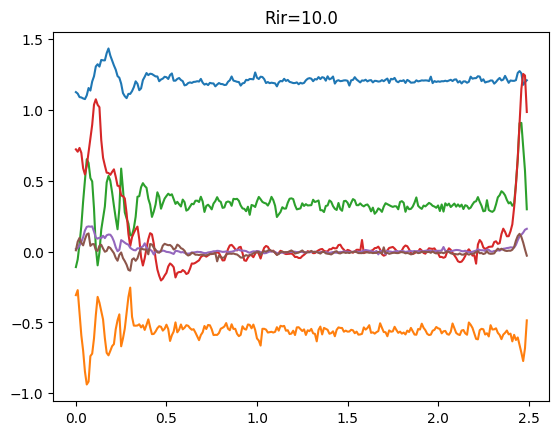

In [323]:
i = 0
plt.plot(X_windowed[i])
t = window_size / 5
tt = window_t / 5
plt.xticks(np.arange(0, window_size+1, t), np.arange(i*stride_t, i*stride_t + window_t + tt, tt));
plt.title(f'Rir={y_windowed[i]}')

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1780, 250, 6) (445, 250, 6)


In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))
mean_squared_error(y_test, y_pred)

In [184]:
regr.rvalue**2

np.float64(0.6565194283398438)

Text(0, 0.5, 'Predicted RIR')

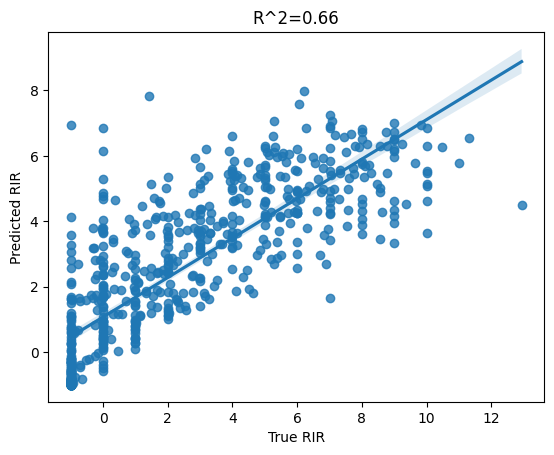

In [185]:
from scipy.stats import linregress
import seaborn as sns
regr = linregress(y_test, y_pred)
sns.regplot(x=y_test, y=y_pred)
plt.title(f'R^2={regr.rvalue**2:.2f}')
plt.xlabel('True RIR')
plt.ylabel('Predicted RIR')